In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import pathlib


# a) Berechnen Sie p und q fuer diese Polynome.
Wir haben
`(x + 1)(x + 1 + a) = x^2 + (2 + a)x + (1 + a) = x^2 + 2(1 + a/2)x - (-(1 + a))`

Es folgt
`p = (1 + a/2), q = -(1 + a)`

In [2]:
# config vars
OUTDIR="./out"
ALPHA_MIN = 0
ALPHA_MAX = 1

# 'Aufloesung' von alpha. Bei 0.1 kriegt man gute Ergebnisse (Also einen sichtbaren Fehler). Bei 0.5 z.B nicht mehr.
STEP = 0.033

# Alle `float`-Typen, die ausprobiert werden sollen
FLOAT_TYPES=[np.float128, np.float64, np.float32, np.float16] 

# b) Implementieren Sie φ(p, q)...

In [3]:
def get_pq0(p, q, float_t=np.float64):
    rp = float_t(p)
    rq = float_t(q)

    pos_sq = -rp + math.sqrt((rp**2) + rq)
    neg_sq = -rp - math.sqrt((rp**2) + rq)
    
    return [pos_sq, neg_sq]

def get_alphas(s_min, s_max, step, float_t=np.float64):
    total_steps = int((s_max - s_min)/step)

    return [float_t(step * n) + s_min for n in range(total_steps + 1)]

def get_pq(a, float_t=np.float64):
    ra = float_t(a)
    return [(1 + ra/2), -(1 + ra)]



# ...und plotten Sie den Fehler zu der tatsaechlichen Nullstelle ueber α mit ausreichend Aufloesung in α.

In [4]:
def get_err(float_t=np.float64):
    alphas = get_alphas(ALPHA_MIN, ALPHA_MAX, STEP, float_t)

    # bei jedem wert von alpha gibt es 2 nullstellen. das output ist also ein
    # vektor
    pq_zeros = np.array([get_pq0(*get_pq(a), float_t=float_t) for a in alphas])
    alg_zeros = np.array([[-1, -(1 + a)] for a in alphas])


    # fuer jeden Wert von α gibt es 2 Nullstellen. Durch ausprobieren haben wir festgestellt,
    # dass die positive Wurzel von (p^2) + q der Nullstelle -1 entspricht. Dieser Wert ist immer
    # in der ersten Stelle von dem array, was von `get_pq0` erzeugt wird.
    err_pos = [np.abs(pq[0] - alg[0]) for (pq, alg) in zip(pq_zeros, alg_zeros)]
    err_neg = [np.abs(pq[1] - alg[1]) for (pq, alg) in zip(pq_zeros, alg_zeros)]
    

    return {"alphas": alphas, 
            "pq_zeros": pq_zeros, 
            "alg_zeros": alg_zeros, 
            "err_pos": err_pos,
            "err_neg": err_neg}
    


def get_err_plot(alphas, err_pos, err_neg, float_t=np.float64):
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].scatter(alphas, err_pos)
    axs[0].set_title(f"α vs. err ({float_t})\nNullstelle -1")
    axs[0].set_xlabel("α")
    axs[0].set_ylabel("err")

    axs[1].scatter(alphas, err_neg)
    axs[1].set_title(f"α vs. err ({float_t})\nNullstelle -(1 + α) ")
    axs[1].set_xlabel("α")
    axs[1].set_ylabel("err")
    
    fig.suptitle("Grafik 1: Fehler von φ")
    return fig

In [5]:
outdir = pathlib.Path("./out")
outdir.mkdir(exist_ok=True)
path = outdir / f"alpha_vs_err_default"

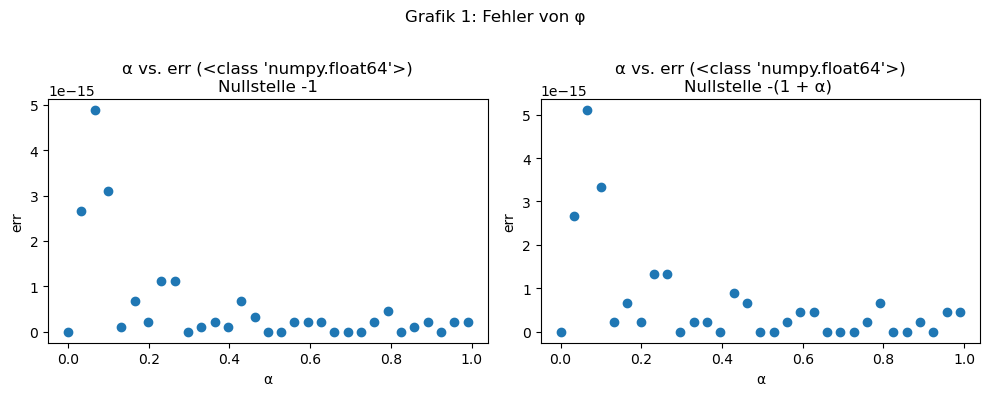

In [6]:
alphas, pq_zeros, alg_zeros, err_pos, err_neg = get_err().values();
fig = get_err_plot(alphas, err_pos, err_neg)
plt.tight_layout()
fig.savefig(path)


# c) Erklaeren Sie den Plot mit dem Wissen ueber die schlechte Kondition von φ (Praesenzblatt).
Laut dem Praesenzblatt ist φ gutkonditioniert wenn  `q > 0` und schlechtkonditioniert, z.B wenn `q ~= -p^2`. Unten sehen wir eine Grafik mit dem Verhaeltnis zwischen `q` und `α`:

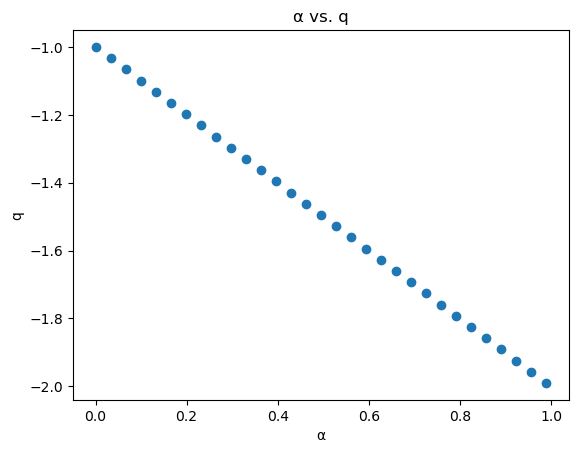

In [7]:
q_vals = [get_pq(a)[1] for a in alphas]
plt.scatter(alphas, q_vals)
plt.title(f"α vs. q")
plt.xlabel("α")
plt.ylabel("q")
plt.show()

`q` ist also fuer unsere Wahl von α stets negativ. Je groesser α, desto negativer `q`. φ ist also in dieser Hinsicht vom Anfang an *NICHT* gutkonditioniert.

Die andere Bedingung, die dazu fuehren soll, dass φ schlechtkonditioniert ist, ist `q ~= -p^2`. Unten sehen wir eine Grafik von diesem Verhaeltnis:

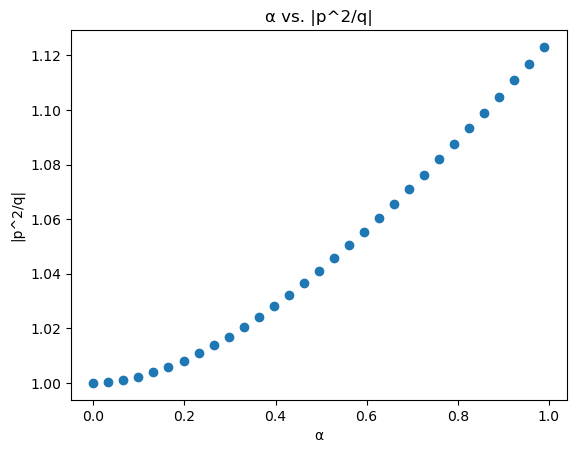

In [8]:
mp2_q_vals = [np.abs((get_pq(a)[0])**2/get_pq(a)[1]) for a in alphas]
plt.scatter(alphas, mp2_q_vals)
plt.title(f"α vs. |p^2/q|")
plt.xlabel("α")
plt.ylabel("|p^2/q|")
plt.show()

Also `q ~= -p^2`, wenn α relativ klein ist. Sie gehen weiter auseinander, je groesser α wird. Allerdings sieht man in Grafik 1, dass mehr Fehler fuer kleinere Werte von α auftreten als fuer grosse Werte von α, was mit der Erwartung uebereinstimmt.

# d) Vergleichen Sie die Plots fuer Gleitkommazahlen mit verschiedener Praezision.

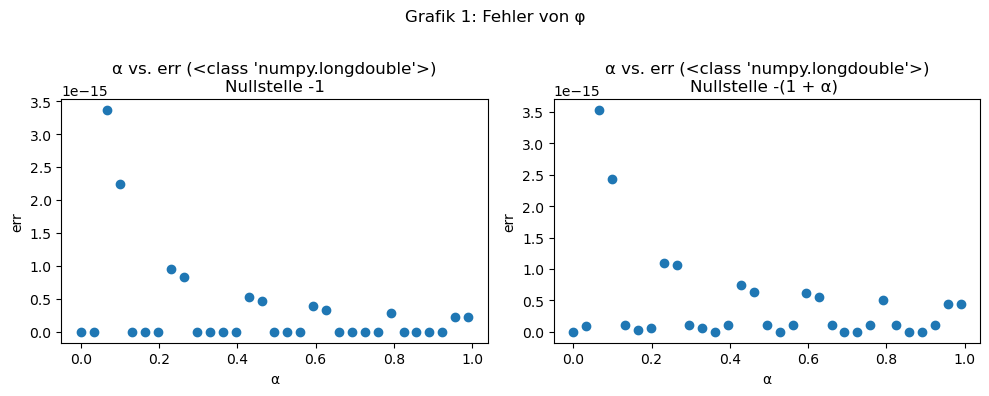

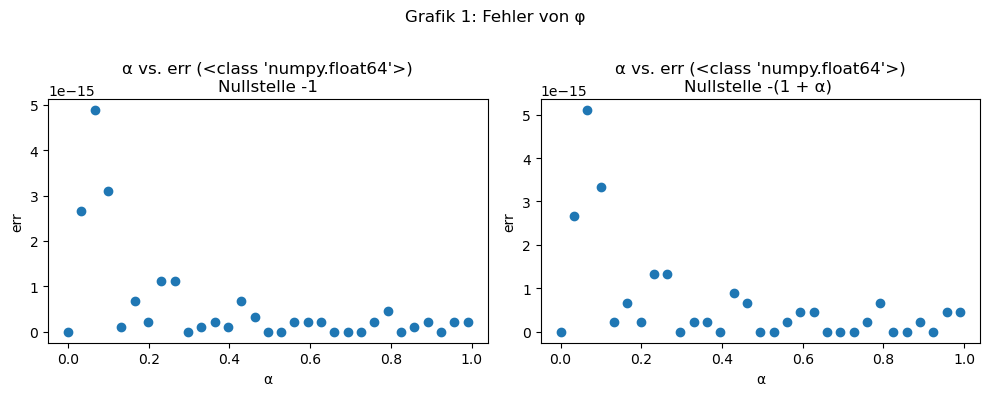

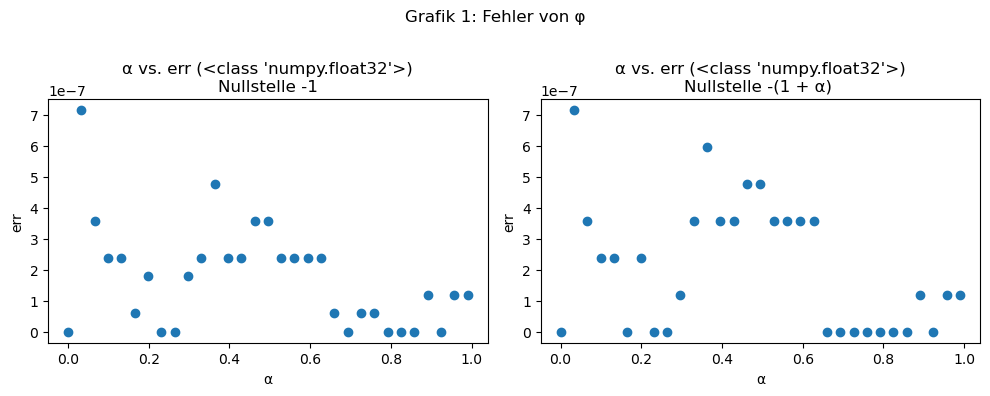

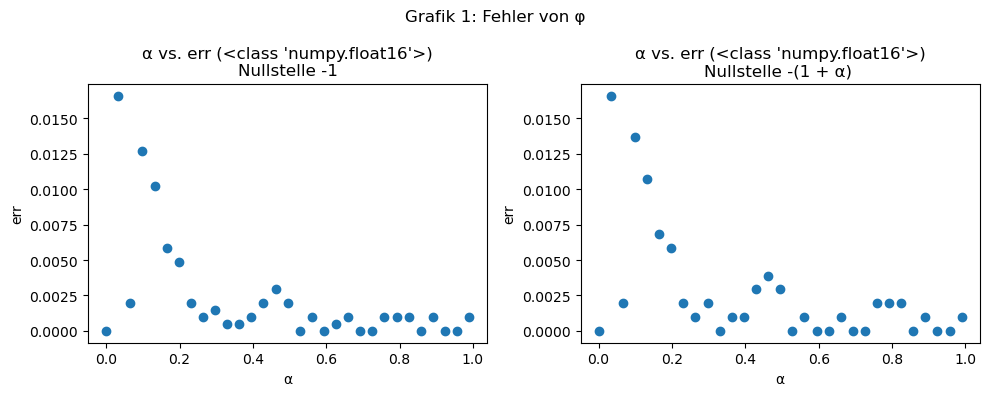

In [9]:
for idx, float_t in enumerate(FLOAT_TYPES):
    path = outdir / f"alpha_vs_err_{idx}"
    alphas, pq_zeros, alg_zeros, err_pos, err_neg = get_err(float_t=float_t).values();
    fig = get_err_plot(alphas, err_pos, err_neg, float_t=float_t)
    plt.tight_layout()
    fig.savefig(path)


Aus dem Vergleich oben wird klar, dass eine kleinere Mantissa in der Regel zu hoeherem Fehler fuerht. Besonders merklich wird das, wenn man sich die Skala anschaut. Wo der Fehler bei `longdouble` (128 bits) der Ordnung `1e-15` ist, sieht man bei `float16` einen Fehler der Ordnung `1e-2`. 